In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
import matplotlib.pyplot as plt

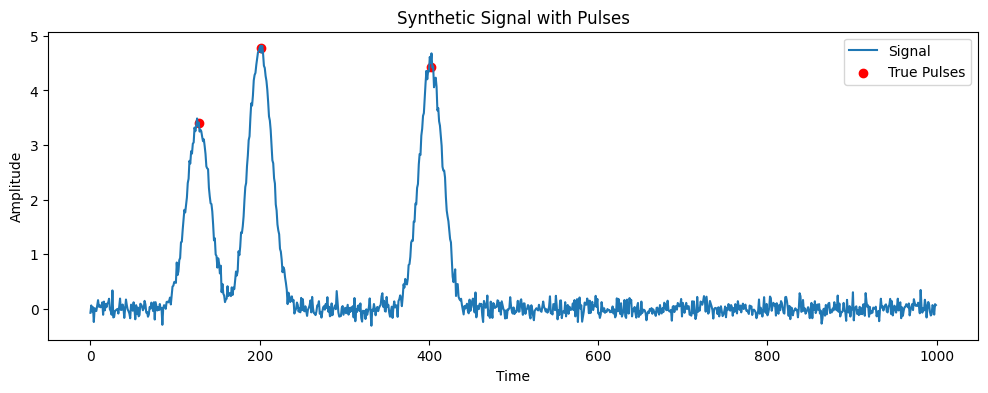

In [9]:
# Generate Synthetic Data
def generate_signal_with_pulses(signal_length=200, num_pulses=3, noise_level=0.1):
    """Generate synthetic signal with pulses and noise."""
    signal = np.zeros(signal_length)
    positions = np.random.randint(0, signal_length, num_pulses)
    heights = np.random.uniform(1, 5, num_pulses)

    for pos, height in zip(positions, heights):
        pulse_width = 80
        pulse = height * np.exp(-np.linspace(-2, 2, pulse_width)**2)
        start = max(0, pos - pulse_width // 2)
        end = min(signal_length, start + pulse_width)
        signal[start:end] += pulse[:end - start]

    signal += np.random.normal(0, noise_level, signal_length)
    return signal, positions, heights

# Generate synthetic data
signal_length = 1000
signal, true_positions, true_heights = generate_signal_with_pulses(signal_length)

# Plot synthetic signal
plt.figure(figsize=(12, 4))
plt.plot(signal, label="Signal")
plt.scatter(true_positions, true_heights, color="red", label="True Pulses")
plt.legend()
plt.title("Synthetic Signal with Pulses")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [10]:
# Extract Regions Based on Classification (Simulated)
def extract_regions(signal, threshold=0.5):
    """Extract regions where the signal exceeds a threshold."""
    regions = []
    current_region = []

    for i, value in enumerate(signal):
        if value > threshold:
            current_region.append(i)
        elif current_region:
            regions.append(current_region)
            current_region = []

    if current_region:
        regions.append(current_region)

    return regions

classified_regions = extract_regions(signal, threshold=0.8)

# Prepare Data for Regression Model
def prepare_training_data(signal, regions, true_positions, true_heights, window_size=20):
    """Prepare input and target data for regression model."""
    X, y = [], []

    for region in regions:
        start = max(0, region[0] - window_size // 2)
        end = min(len(signal), region[-1] + window_size // 2)
        window = signal[start:end]
        padded_window = np.pad(window, (0, window_size - len(window)), mode="constant")
        
        # Find the true pulse in this region
        region_true_positions = [pos for pos in true_positions if region[0] <= pos <= region[-1]]
        region_true_heights = [height for pos, height in zip(true_positions, true_heights) if region[0] <= pos <= region[-1]]

        if region_true_positions:
            X.append(padded_window)
            y.append([region_true_positions[0] - region[0], region_true_heights[0]])

    return np.array(X), np.array(y)

In [12]:
X_train, y_train = prepare_training_data(signal, classified_regions, true_positions, true_heights)

ValueError: index can't contain negative values

In [ ]:
# Build Regression Model
def build_regression_model(input_size):
    """Build a simple regression model."""
    model = Sequential([
        Input(shape=(input_size,)),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(2)  # Output: [position_offset, height]
    ])
    model.compile(optimizer="adam", loss="mse")
    return model

regression_model = build_regression_model(X_train.shape[1])

# Train Regression Model
regression_model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

# Test the Model
def infer_pulses(signal, regions, model, window_size=20):
    """Infer pulse positions and heights from the signal using the trained model."""
    inferred_positions = []
    inferred_heights = []

    for region in regions:
        start = max(0, region[0] - window_size // 2)
        end = min(len(signal), region[-1] + window_size // 2)
        window = signal[start:end]
        padded_window = np.pad(window, (0, window_size - len(window)), mode="constant")

        prediction = model.predict(padded_window[np.newaxis, :])[0]
        inferred_positions.append(region[0] + prediction[0])
        inferred_heights.append(prediction[1])

    return np.array(inferred_positions), np.array(inferred_heights)

inferred_positions, inferred_heights = infer_pulses(signal, classified_regions, regression_model)

# Plot Results
plt.figure(figsize=(12, 4))
plt.plot(signal, label="Signal")
plt.scatter(true_positions, true_heights, color="red", label="True Pulses")
plt.scatter(inferred_positions, inferred_heights, color="green", label="Inferred Pulses")
plt.legend()
plt.title("Pulse Detection: True vs Inferred")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()
